# Header

In [1]:
import numpy as np
import pandas as pd
from healpy.sphtfunc import smoothing
import smica
import os
import json
import component_separation
from astropy.io import fits
from scipy import interpolate
from component_separation.io import IO
import healpy as hp
import component_separation.interface as cslib
import component_separation.MSC.MSC.pospace as ps
import component_separation.powspec as pw

from component_separation.cs_util import Config
from component_separation.cs_util import Constants as const
from component_separation.cs_util import Helperfunctions as hpf
from component_separation.cs_util import Planckf, Planckr, Plancks
import matplotlib.pyplot as plt
csu = Config()
io = IO(csu)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

lmax=csu.lmax
nside_out = csu.nside_out
bins = csu.bins
detector = csu.PLANCKMAPFREQ_f
specfilter = csu.specfilter
freqfilter = csu.freqfilter

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Run with the following settings:
{'Tscale': 'K_CMB', 'mskset': 'lens', 'freqdset': 'NPIPE', 'Spectrum_scale': 'C_l', 'lmax': 4000, 'lmax_mask': 6000, 'freqdatsplit': '', 'smoothing_window': 0, 'max_polynom': 0, 'num_sim': 5, 'binname': 'SMICA_lowell_bins', 'overwrite_cache': True, 'split': '', 'nside_out': None, 'splitvariation': 'GHz', 'freqfilter': ['545', '857'], 'specfilter': ['TB', 'EB', 'ET', 'BT', 'BE'], 'nside_desc_map': [1024, 2048]}
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
MSC: reverting to standard healpy
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Run with the following settings:
{'Tscale': 'K_CMB', 'mskset': 'lens', 'freqdset': 'NPIPE', 'Spectrum_scale': 'C_l', 'lmax': 4000, 'lmax_mask': 6000, 'freqdatsplit': '', 'smoothing_window': 0, 'max_polynom': 0, 'num_sim': 5, 'binname': 'SMICA_lowell_bins', 'overwrite_cache': True, 'split': '', 'nside_out': None, 'splitvariation': 'GHz', 'freqfilter': ['545', '857'], 'specfilter': ['TB', 'EB', 

/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/pyfits/__init__.py:21: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  warnings.warn('PyFITS is deprecated, please use astropy.io.fits',


# SMICA input

## Header

In [2]:
CMB = dict()
CMB["TQU"] = dict()
CMB["TQU"]["in"] = io.load_data(io.fh.map_cmb_sc_path_name)
CMB["TQU"]['out'] = io.load_data(io.fh.cmbmap_smica_path_name)

C_ltot = io.load_powerspectra('full')
cov_ltot = pw.build_covmatrices(C_ltot, csu.Tscale, csu.freqcomb, csu.PLANCKMAPFREQ_f)
cov_ltotEE = cov_ltot[1]
print(cov_ltotEE.shape)

C_lN = io.load_powerspectra('noise')
cov_lN = pw.build_covmatrices(C_lN, csu.Tscale, csu.freqcomb, csu.PLANCKMAPFREQ_f)
cov_lNEE = cov_lN[1]
print(cov_lNEE.shape)

C_lS = io.load_powerspectra('signal')
# Fakes the same shape so pw.build_covmatrices() may be used
C_lS_shaped = np.zeros_like(C_lN)
for freqcom in range(C_lS_shaped.shape[0]):
    C_lS_shaped[freqcom,1,:] = C_lS[0,1]
cov_lS = pw.build_covmatrices(C_lS_shaped, csu.Tscale, csu.freqcomb, csu.PLANCKMAPFREQ_f)
cov_lSEE = cov_lS[1]
print(cov_lSEE.shape)

cov_ltot_bnd = hpf.bin_it(cov_ltotEE, bins=bins)
print(cov_ltot_bnd.shape)

cov_lN_bnd = hpf.bin_it(cov_lNEE, bins=bins)
cov_lN_bnd = np.diagonal(cov_lN_bnd, axis1=0, axis2=1).T
print(cov_lN_bnd.shape)

cov_lS_bnd =  hpf.bin_it(cov_lSEE, bins=bins)
print(cov_lS_bnd.shape)

loaded /global/cscratch1/sd/sebibel/misc/map_cmb_in_nside_2048_sim_id_0200.npy
loaded /global/cscratch1/sd/sebibel/smica/smicaminvarmap_SMICA_lowell_bins_0200_C_l_NPIPE_lens_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/spectrum/NPIPE/SPEC0200_C_l_NPIPE_lens_4000_6000_0_0_Full.npy
(7, 7, 4001)
loaded /global/cscratch1/sd/sebibel/spectrum/NPIPE_diff/SPEC0200_C_l_NPIPE_diff_lens_4000_6000_0_0_Full.npy
(7, 7, 4001)
loaded /global/cscratch1/sd/sebibel/misc/C_lS_in_sim_id_0200.npy
(7, 7, 4001)
(7, 7, 10)
(7, 10)
(7, 7, 10)


(9, 7, 7, 4001) (1, 6, 4001)


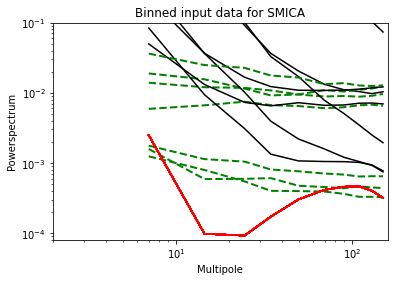

In [3]:
print(cov_lS.shape, C_lS.shape)
for n in range(cov_lN.shape[1]):
    plt.plot(np.mean(bins, axis=1), cov_lN_bnd[n,:], color= 'green', lw=2, label='noise', ls ='--')
#     plt.plot(cov_lN[1,n,n,:], color= 'green', lw=2, label='noise',ls ='--')
    for m in range(cov_ltot_bnd.shape[1]):
        if n==m:
            plt.plot(np.mean(bins, axis=1), cov_ltot_bnd[n,m,:], color = 'black', label='full')
            
# plt.plot(C_lS[0,1,:], color= 'red', lw=2, label='signal')
for n in range(cov_lS_bnd.shape[0]):
    for m in range(cov_lS_bnd.shape[1]):
        plt.plot(np.mean(bins, axis=1), cov_lS_bnd[n,m,:], color = 'red', label='signal')
      
            
# plt.axvspan(bins[-1][1], lmax, facecolor='wheat', alpha=0.5)
# plt.text(700, 1e-2, 'Not in SMICA fit', bbox=props)
                   
plt.ylim((8e-5,1e-1))
plt.xlim((2,bins[-1,1]))
plt.xlabel('Multipole')
plt.ylabel('Powerspectrum')
plt.title('Binned input data for SMICA')
plt.yscale('log')
plt.xscale('log')

# SMICA output

## Header

In [4]:
filename = io.fh.total_filename
cmb_specsmica_sc_path_name = io.fh.cmb_specsmica_sc_path_name

smica_cmb = io.load_data(cmb_specsmica_sc_path_name)
tf = io.load_data(io.fh.out_misc_path+"tf_{}".format(csu.binname) + "_" + filename)
C_lS_in = io.load_data(io.fh.signal_sc_path_name)[0,1]
smicaclmin = io.load_data(io.fh.clmin_smica_path_name)
C_lS_out = io.load_data(io.fh.cmb_specsmica_sc_path_name)[0,0] #this is EE, as smica runs for EE only!
C_ltot = io.load_data(path_name=io.fh.spec_sc_path_name)

cov_ltot = pw.build_covmatrices(C_ltot, csu.Tscale, csu.freqcomb, csu.PLANCKMAPFREQ_f)

loaded /global/cscratch1/sd/sebibel/smica/NPIPE/CMB_SPECSMICA_SMICA_lowell_bins0200_C_l_NPIPE_lens_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/misc/tf_SMICA_lowell_bins_0200_C_l_NPIPE_lens_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/misc/C_lS_in_sim_id_0200.npy
loaded /global/cscratch1/sd/sebibel/smica/smicaclmin_SMICA_lowell_bins_0200_C_l_NPIPE_lens_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/smica/NPIPE/CMB_SPECSMICA_SMICA_lowell_bins0200_C_l_NPIPE_lens_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/spectrum/NPIPE/SPEC0200_C_l_NPIPE_lens_4000_6000_0_0_Full.npy


## Transferfunction

(159,)


(0.0, 159.0)

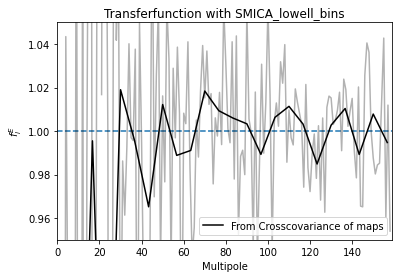

In [12]:
print(tf.shape)
lmaxbins = int(bins[-1][1])
mean, err, _ = hpf.std_dev_binned(tf, lmax=lmaxbins, binwidth=25, log=False)
plt.errorbar((_[1:] + _[:-1])/2, mean, color='black', label = 'From Crosscovariance of maps')
# plt.axvspan(bins[-1][1], lmax, facecolor='wheat', alpha=0.5)
# plt.text(1100, 1.04, 'Extrapolated', bbox=props)
plt.plot(tf, color='black', alpha=0.3)
plt.legend()
plt.ylim((0.95,1.05))
plt.hlines(1,0,lmaxbins,ls='--')
plt.title(r'Transferfunction with {}'.format(csu.cf['pa']['binname']))
plt.ylabel(r'$f_l^E$')
plt.xlabel('Multipole')
plt.xlim((0,lmaxbins))

## Fit

(0.0, 159.0)

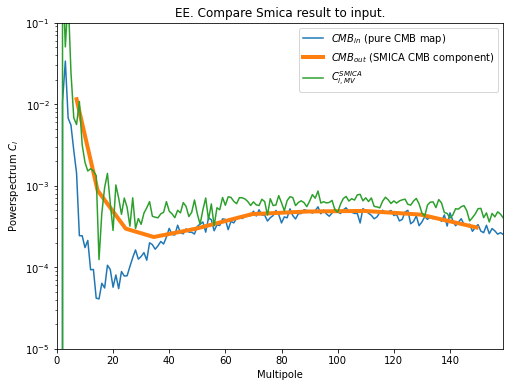

In [5]:
plt.figure(figsize=(8,6))
plt.plot(C_lS_in, label=r'$CMB_{in}$ (pure CMB map)')
plt.plot(np.mean(bins, axis=1), 
         C_lS_out, 
         label=r'$CMB_{out}$ (SMICA CMB component)', lw=4)
plt.plot(smicaclmin[0], label=r'$C^{SMICA}_{l,MV}$')
plt.ylim((1e-5, 1e-1))
plt.legend()
plt.title(r'EE. Compare Smica result to input.')
plt.ylabel(r'Powerspectrum $C_l$')
plt.xlabel('Multipole')
plt.yscale('log')
plt.xlim((0,bins[-1][1]))

# Weights

loaded /global/cscratch1/sd/sebibel/weights/NPIPE/WEIG_K_CMB_0200_C_l_NPIPE_lens_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/smica/SMICAWEIG_K_CMB_SMICA_lowell_bins0200_C_l_NPIPE_lens_4000_6000_0_0_Full.npy
(9, 7, 4001)
(9, 7, 10)


/global/u2/s/sebibel/git/component_separation/component_separation/cs_util.py:679: RuntimeWarning: invalid value encountered in true_divide
  mean = sy / n
/global/u2/s/sebibel/git/component_separation/component_separation/cs_util.py:680: RuntimeWarning: invalid value encountered in true_divide
  std = np.sqrt(sy2/n - mean*mean)
/global/u2/s/sebibel/git/component_separation/component_separation/cs_util.py:679: RuntimeWarning: invalid value encountered in true_divide
  mean = sy / n
/global/u2/s/sebibel/git/component_separation/component_separation/cs_util.py:680: RuntimeWarning: invalid value encountered in true_divide
  std = np.sqrt(sy2/n - mean*mean)
/global/u2/s/sebibel/git/component_separation/component_separation/cs_util.py:680: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(sy2/n - mean*mean)
/global/u2/s/sebibel/git/component_separation/component_separation/cs_util.py:679: RuntimeWarning: invalid value encountered in true_divide
  mean = sy / n
/global/u2/s/s

(10, 4000)

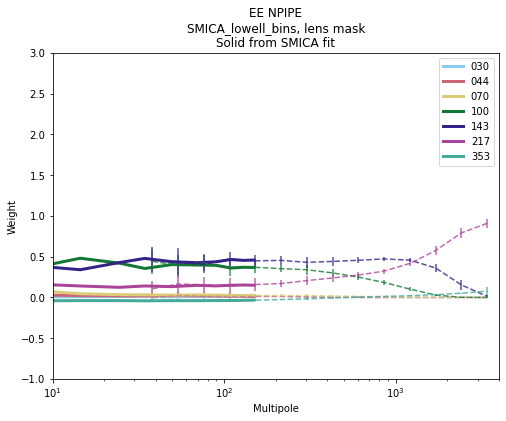

In [6]:
W_data = io.load_data(io.fh.weight_path_name)
W_smica = io.load_data(io.fh.weight_smica_path_name)
colors = csu.CB_color_cycle
specID=1
fig = plt.figure(figsize=(8,6))
print(W_data.shape)
print(W_smica.shape)
xnew = np.arange(0,lmax,1)
for freq in range(W_smica.shape[1]):
    W_Einterp = interpolate.interp1d(np.mean(bins, axis=1), W_smica[1,freq,:], bounds_error = False, fill_value='extrapolate')
    mean, err, _ = hpf.std_dev_binned(W_data[specID,freq,:], lmax=W_data.shape[2], binwidth=25, log=True)
    plt.errorbar(((_[1:]+_[:-1])/2)[10:], mean[10:], yerr=err[10:], color=colors[freq], alpha=0.8, ls = '--')
    plt.plot(np.mean(bins, axis=1), W_smica[specID,freq,:], color=colors[freq], label=csu.PLANCKMAPFREQ[freq], lw=3)
#     plt.plot(W_Einterp(xnew))
plt.legend()
plt.ylim((-1,3))
plt.title('EE {}\n{}, {} mask\nSolid from SMICA fit'.format(csu.cf['pa']['freqdset'], csu.binname, csu.cf['pa']['mskset']))
plt.xlabel('Multipole')
plt.ylabel('Weight')
# plt.text(1200, 0.8, 'EE Spectra', bbox=props)
# plt.text(1100, 0.8, 'Extrapolated', bbox=props)
# plt.axvspan(bins[-1][1], lmax, facecolor='wheat', alpha=0.5)
plt.xscale('log')
plt.xlim((10,lmax))

# Cross-Covariance

## Header

In [9]:
CMB = io.load_data(io.fh.map_cmb_sc_path_name)
MV = io.load_data(io.fh.cmbmap_smica_path_name)
crosscov = io.load_data(io.fh.out_misc_path+"crosscov_{}".format(csu.binname) + "_" + filename)

loaded /global/cscratch1/sd/sebibel/misc/map_cmb_in_nside_2048_sim_id_0200.npy
loaded /global/cscratch1/sd/sebibel/smica/smicaminvarmap_SMICA_lowell_bins_0200_C_l_NPIPE_sim_None_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/misc/crosscov_SMICA_lowell_bins_0200_C_l_NPIPE_sim_None_4000_6000_0_0_Full.npy


## Spectrum

(0.0, 159.0)

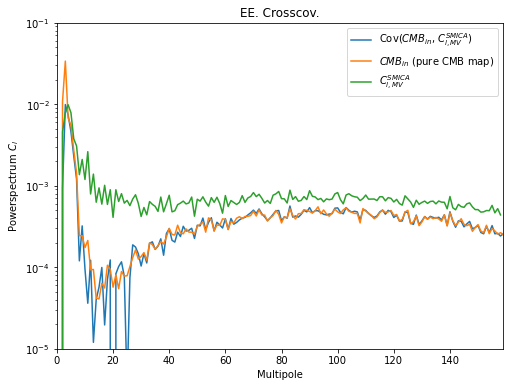

In [10]:
plt.figure(figsize=(8,6))
plt.plot(crosscov[0], label=r'Cov($CMB_{in}$, $C^{SMICA}_{l,MV}$)')
plt.plot(C_lS_in, label=r'$CMB_{in}$ (pure CMB map)')
plt.plot(smicaclmin[0][:int(bins[-1][1])], label=r'$C^{SMICA}_{l,MV}$')

plt.ylim((1e-5, 1e-1))
plt.legend()
plt.title(r'EE. Crosscov.')
plt.ylabel(r'Powerspectrum $C_l$')
plt.xlabel('Multipole')
plt.yscale('log')
plt.xlim((0,bins[-1][1]))

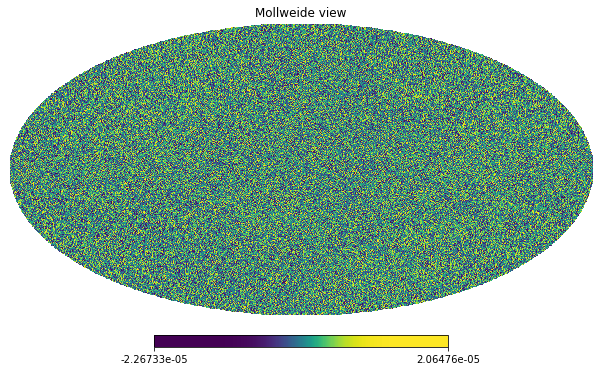

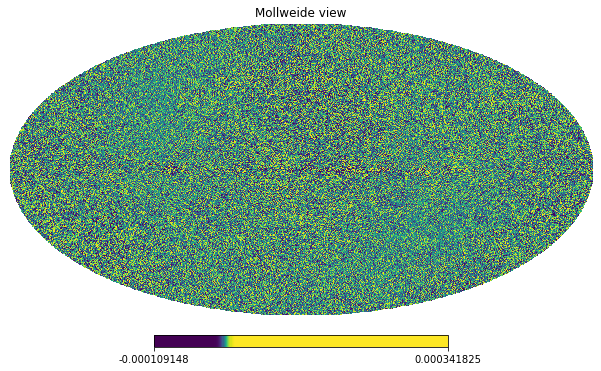

In [11]:
hp.mollview(CMB[2], norm='hist')
hp.mollview(MV[2],norm='hist')

# NPIPE Simulation Data

In [ ]:
hdul = fits.open("/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/noisefix/noisefix_143_0200.fits") # <- IQU, nested order
hdul[1].header
hp.mollview(hdul[1].data.field(0).reshape(-1), nest=True, norm='hist',remove_dip=True)

### npipe6v20_143_map.fits

/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                49152 / width of table in bytes                        
NAXIS2  =                12288 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    3 / number of fields in each row                   
TTYPE1  = 'TEMPERATURE'        / label for field   1                            
TFORM1  = '4096E   '           / data format of field: 4-byte REAL              
TUNIT1  = 'K_CMB   '           / physical unit of field                         
TTYPE2  = 'Q-POLARISATION'     / label for field   2                            
TFORM2  = '4096E   '        

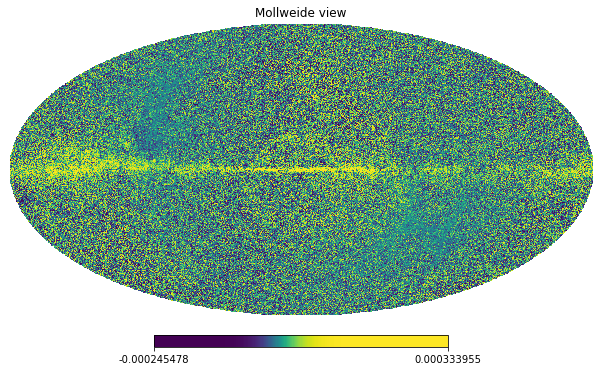

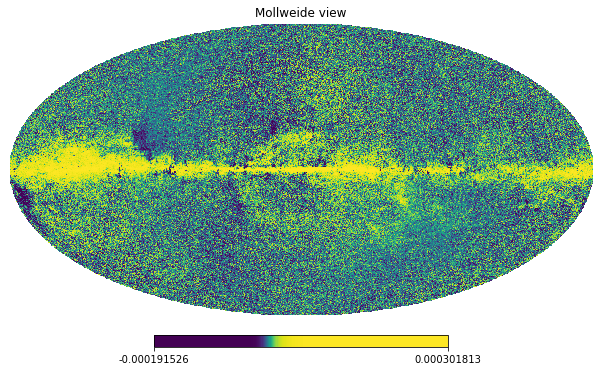

In [148]:
hdul = fits.open("/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/npipe6v20_143_map.fits")
hp.mollview(hdul[1].data.field(1).reshape(-1), nest=True, norm='hist')
hdul[1].header
hdul0f0dg = hp.ud_grade(hdul[1].data.field(0).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hdul0f1dg = hp.ud_grade(hdul[1].data.field(1).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hdul0f2dg = hp.ud_grade(hdul[1].data.field(2).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hp.mollview(hdul0f1dg, nest=False, norm='hist', gal_cut = 15)
hdul[1].header

In [133]:
cl0 = hp.anafast([hdul0f0dg,hdul0f1dg, hdul0f2dg], gal_cut = 5)
print(cl0.shape)

(6, 1536)


/global/common/cori_cle7/software/python/3.8-anaconda-2020.11/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/common/cori_cle7/software/python/3.8-anaconda-2020.11/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(100.0, 1500.0)

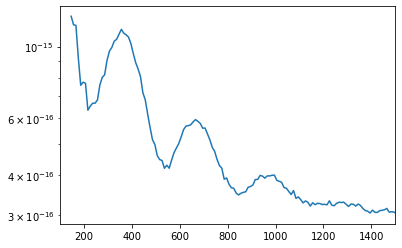

In [131]:
plt.plot(np.mean(bins,axis=1), hpf.bin_it1D(cl0[1]))
plt.yscale('log')
plt.xlim((100,1500))

### input/ffp10_cmb_143_alm_mc_0200.fits
This is what expected cmb looks like

In [3]:
hdul = fits.open("/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/input/ffp10_cmb_143_alm_mc_0200.fits")
real = hdul[1].data.field(1)
imag = hdul[1].data.field(2)
data = real + 1j * imag
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   20 / length of dimension 1                          
NAXIS2  =              8394753 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'index   '                                                            
TFORM1  = 'J       '                                                            
TUNIT1  = 'l*l+l+m+1'                                                           
TTYPE2  = 'real    '                                                            
TFORM2  = 'D       '        

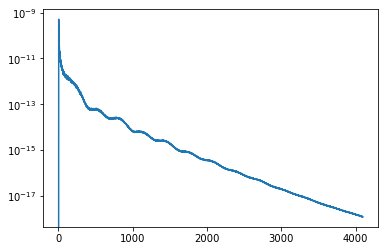

In [36]:
cl1 = hp.alm2cl(data)
print(cl1.shape)
plt.plot(cl1)
# plt.plot(cl1[1])
plt.yscale('log')

### input/ffp10_cmb_143_alm_mc_0200_nside2048_quickpol.fits

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                12288 / length of dimension 1                          
NAXIS2  =                12288 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'TEMPERATURE'                                                         
TFORM1  = '1024E   '                                                            
TTYPE2  = 'Q_POLARISATION'                                                      
TFORM2  = '1024E   '                                                            
TTYPE3  = 'U_POLARISATION'  

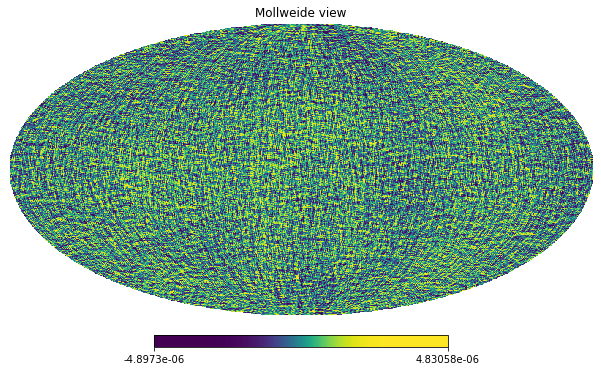

In [381]:
hdul = fits.open("/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/input/ffp10_cmb_030_alm_mc_0200_nside1024_quickpol.fits")
hp.mollview(hdul[1].data.field(1).reshape(-1), nest=True, norm='hist')
hdul[1].header

In [154]:
cl = dict()
for det in detector:
    if int(det)<100:
            nside_desc = cf['pa']['nside_desc_map'][0]
    else:
        nside_desc = cf['pa']['nside_desc_map'][1]
    hdul = fits.open("/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/input/ffp10_cmb_{det}_alm_mc_0200_nside{nside}_quickpol.fits".format(det=det, nside=nside_desc))
    hdul2f0dg = hp.ud_grade(hdul[1].data.field(0).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
    hdul2f1dg = hp.ud_grade(hdul[1].data.field(1).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
    hdul2f2dg = hp.ud_grade(hdul[1].data.field(2).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
    cl[det] = hp.anafast([hdul2f0dg,hdul2f1dg, hdul2f2dg])

In [160]:
detector = csu.PLANCKMAPFREQ_f
beamf = io.load_beamf(csu.freqcomb)
bf = dict()
for det in detector:
    bf[det+'-'+det] = beamf[det+'-'+det]["HFI"][1].data.field(1)[:768]

<ipython-input-165-8adf605d6f94>:4: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(spectrum_trth[:4000+1]/hpf.llp1e12(np.arange(0,4001,1)), label='Planck EE best estimate')


(0.0, 750.0)

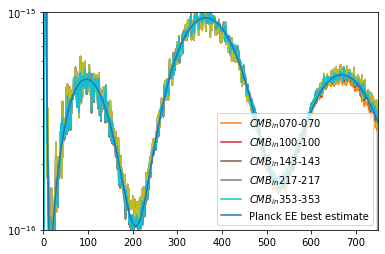

In [165]:
for det in detector:
    plt.plot(covlsmin[0]*hp.gauss_beam(np.radians(5/60),lmax=750)**2)
    plt.plot(cl[det][1]/(bf[det+'-'+det]**2*hp.pixwin(nside_out, pol=True, lmax=767)[0]**2), label=r'$CMB_{in}$' +'{det}-{det}'.format(det=det))
plt.plot(spectrum_trth[:4000+1]/hpf.llp1e12(np.arange(0,4001,1)), label='Planck EE best estimate')
plt.legend()
plt.yscale('log')
plt.ylim((1e-16,1e-15))
plt.xlim((0,750))

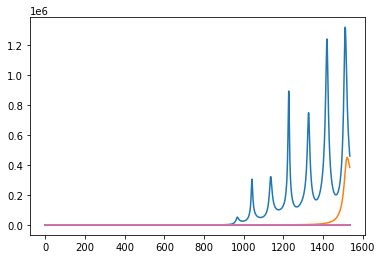

In [374]:
for det in detector:
    plt.plot(1/bf[det+'-'+det])

In [274]:
alms = hp.map2alm([hdul2f0dg,hdul2f1dg, hdul2f2dg])

In [349]:
almsp = np.array([hp.almxfl(alm, 1/bf353) for iterator, alm in enumerate(alms[1:])])
almsp = [hp.almxfl(alm, 1/hp.pixwin(nside_out, pol=True, lmax=1535)[iterator]) for iterator, alm in enumerate(almsp)]

<ipython-input-349-a67b16212772>:2: RuntimeWarning: divide by zero encountered in true_divide
  almsp = [hp.almxfl(alm, 1/hp.pixwin(512, pol=True, lmax=1535)[iterator]) for iterator, alm in enumerate(almsp)]


<ipython-input-259-6977972379fd>:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot((cl2[1]/(bf143**2*hp.pixwin(512, pol=True, lmax=1535)[1]**2))/(cl353[1]/(bf353**2*hp.pixwin(512, pol=True, lmax=1535)[1]**2)))


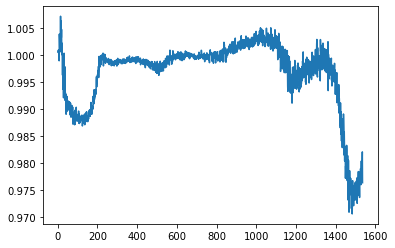

In [259]:
plt.plot((cl2[1]/(bf143**2*hp.pixwin(nside_out, pol=True, lmax=1535)[1]**2))/(cl353[1]/(bf353**2*hp.pixwin(512, pol=True, lmax=1535)[1]**2)))

### residual/residual_npipe6v20_143_0200.fits

/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                12288 / length of dimension 1                          
NAXIS2  =                49152 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'TEMPERATURE'                                                         
TFORM1  = '1024E   '                                                            
TTYPE2  = 'Q_POLARISATION'                                                      
TFORM2  = '1024E   '                                                            
TTYPE3  = 'U_POLARISATION'  

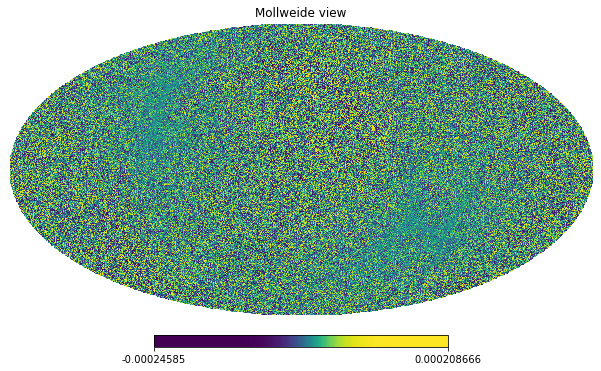

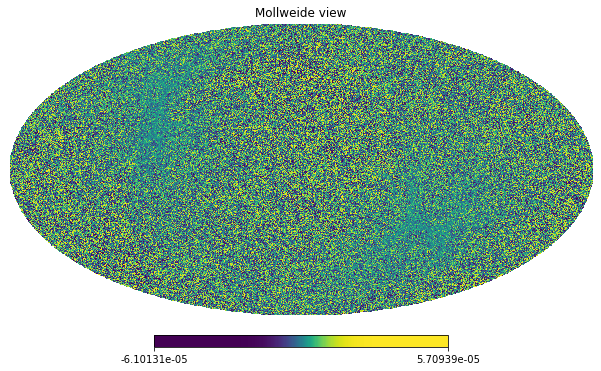

In [3]:
hdul = fits.open("/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/residual/residual_npipe6v20_143_0200.fits")
hp.mollview(hdul[1].data.field(1).reshape(-1), norm='hist')
hdul[1].header
nside_out = 512
hdul3f0dg = hp.ud_grade(hdul[1].data.field(0).reshape(-1), nside_out = nside_out)
hdul3f1dg = hp.ud_grade(hdul[1].data.field(1).reshape(-1), nside_out = nside_out)
hdul3f2dg = hp.ud_grade(hdul[1].data.field(2).reshape(-1), nside_out = nside_out)
hp.mollview(hdul3f1dg, norm='hist')
hdul[1].header

(6, 1536)


(2e-16, 1e-15)

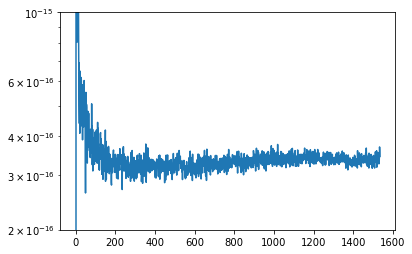

In [4]:
cl3 = hp.anafast([hdul3f0dg,hdul3f1dg, hdul3f2dg])
print(cl3.shape)
plt.plot(cl3[1])
plt.yscale('log')
plt.ylim((2e-16,1e-15))

### noisefix/noisefix_100_0200.fits

/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                12288 / length of dimension 1                          
NAXIS2  =                49152 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'TEMPERATURE'                                                         
TFORM1  = '1024E   '                                                            
TTYPE2  = 'Q_POLARISATION'                                                      
TFORM2  = '1024E   '                                                            
TTYPE3  = 'U_POLARISATION'  

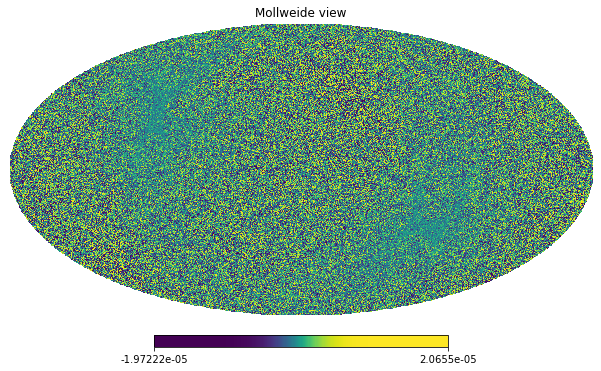

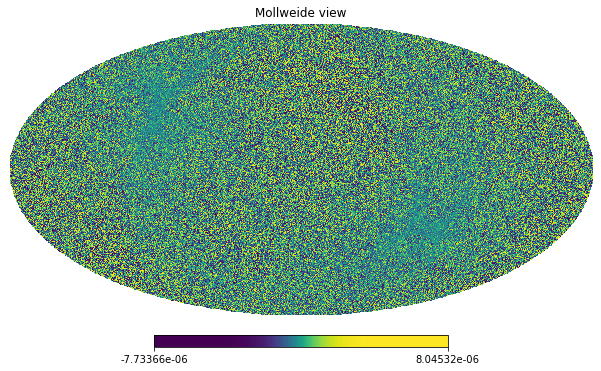

In [144]:
hdul = fits.open("/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/noisefix/noisefix_100_0200.fits")
hp.mollview(hdul[1].data.field(1).reshape(-1), norm='hist', nest=True)
hdul[1].header
nside_out = 512
hdul4f0dg = hp.ud_grade(hdul[1].data.field(0).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hdul4f1dg = hp.ud_grade(hdul[1].data.field(1).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hdul4f2dg = hp.ud_grade(hdul[1].data.field(2).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hp.mollview(hdul4f1dg, norm='hist', nest=False)
hdul[1].header

In [142]:
cl4 = hp.anafast([hdul4f0dg,hdul4f1dg, hdul4f2dg])
print(cl4.shape)

(6, 1536)


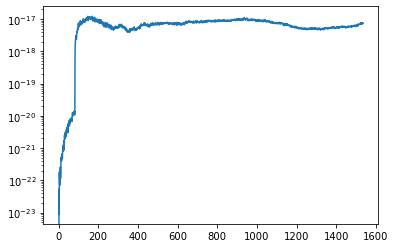

In [143]:
plt.plot(cl4[1])
plt.yscale('log')
# plt.ylim((2e-16,1e-15))

### half_ring

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                49152 / width of table in bytes                        
NAXIS2  =                12288 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    3 / number of fields in each row                   
TTYPE1  = 'TEMPERATURE'        / label for field   1                            
TFORM1  = '4096E   '           / data format of field: 4-byte REAL              
TUNIT1  = 'K_CMB   '           / physical unit of field                         
TTYPE2  = 'Q-POLARISATION'     / label for field   2                            
TFORM2  = '4096E   '        

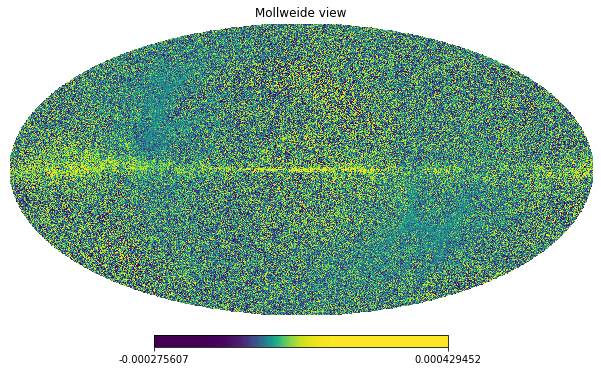

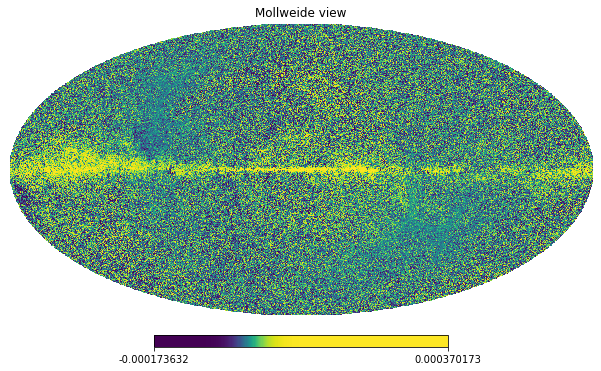

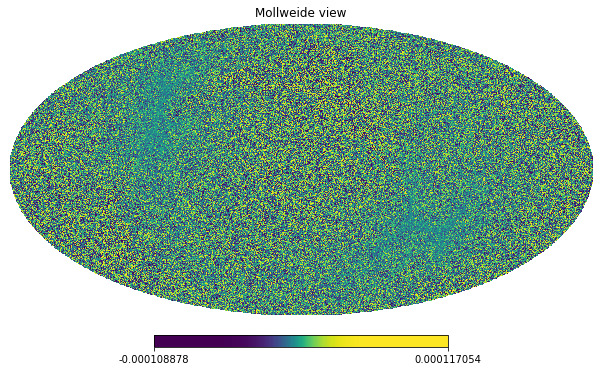

In [145]:
hdul1 = fits.open("/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/half_ring/npipe6v20_143_map_sub1of2.fits")
hdul2 = fits.open("/global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20_sim/0200/half_ring/npipe6v20_143_map_sub2of2.fits")
hp.mollview(hdul1[1].data.field(1).reshape(-1), norm='hist', nest=True)
hdul1[1].header
nside_out = 512
hdul14f0dg = hp.ud_grade(hdul1[1].data.field(0).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hdul14f1dg = hp.ud_grade(hdul1[1].data.field(1).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hdul14f2dg = hp.ud_grade(hdul1[1].data.field(2).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')

hdul24f0dg = hp.ud_grade(hdul2[1].data.field(0).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hdul24f1dg = hp.ud_grade(hdul2[1].data.field(1).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')
hdul24f2dg = hp.ud_grade(hdul2[1].data.field(2).reshape(-1), nside_out = nside_out, order_in = 'NESTED', order_out='RING')

hp.mollview(hdul14f1dg, norm='hist', nest=False)


d1_hdulf0dg = (hdul14f0dg - hdul24f0dg)/2.
d1_hdulf1dg = (hdul14f1dg - hdul24f1dg)/2.
d1_hdulf2dg = (hdul14f2dg - hdul24f2dg)/2.
hp.mollview(d1_hdulf1dg, norm='hist', nest=False)

hdul1[1].header

In [146]:
dcl5 = hp.anafast([d1_hdulf0dg,d1_hdulf1dg, d1_hdulf2dg])
print(dcl5.shape)

(6, 3072)


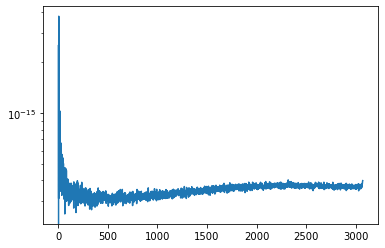

In [147]:
plt.plot(dcl5[1])
plt.yscale('log')

/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/s/sebibel/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/he

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4096 / length of dimension 1                          
NAXIS2  =                49152 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    1 / number of table fields                         
TTYPE1  = 'I       '                                                            
TFORM1  = '1024E   '                                                            
PIXTYPE = 'HEALPIX '           / HEALPIX pixelisation                           
ORDERING= 'RING    '           / Pixel ordering scheme, either RING or NESTED   
EXTNAME = 'xtension'        

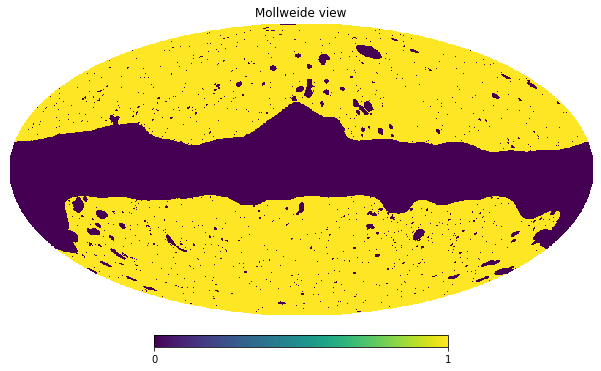

In [2]:
import healpy as hp
from astropy.io import fits
pmask = hp.read_map("/global/homes/s/sebibel/data/mask/PR3vJan18_temp_lensingmask_gPR2_70_psPR2_143_COT2_smicadx12_smicapoldx12_psPR2_217_sz.fits.gz")
hdul = fits.open("/global/homes/s/sebibel/data/mask/PR3vJan18_temp_lensingmask_gPR2_70_psPR2_143_COT2_smicadx12_smicapoldx12_psPR2_217_sz.fits.gz")
hp.mollview(pmask)
hdul[1].header